# P4J Periodogram demo

A simple demonstration of P4J's information theoretic periodogram

In [1]:
from __future__ import division
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import P4J
print("P4J version:")
print(P4J.__version__)

P4J version:
0.27


## Generating a simple synthetic light curve
We create an irregulary sampled time series using a harmonic model composed of three sine waves with an specified Signal to Noise Ratio SNR

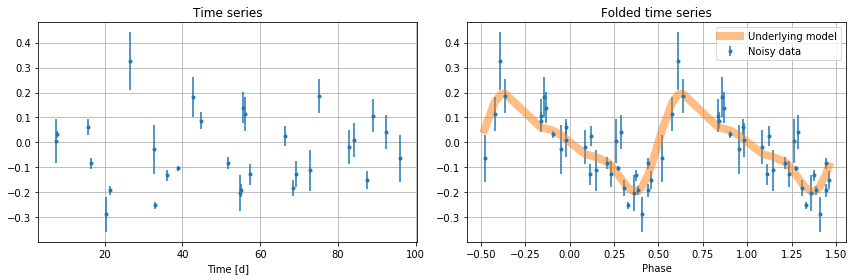

In [2]:
fundamental_freq = 2.0
lc_generator = P4J.synthetic_light_curve_generator(T=100.0, N=30)
lc_generator.set_model(f0=fundamental_freq, A=[1.0, 0.5, 0.25])
mjd, mag, err = lc_generator.draw_noisy_time_series(SNR=5.0, red_noise_ratio=0.25, outlier_ratio=0.0)
c_mjd, c_mag = lc_generator.get_clean_signal()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.errorbar(mjd, mag, err, fmt='.')
ax.set_xlabel('Time [d]')
ax.set_title('Time series')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fundamental_freq)*fundamental_freq
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
            np.concatenate([mag[index], mag[index]]), 
            np.concatenate([err[index], err[index]]), fmt='.', alpha=1.0, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]), 
        np.concatenate([c_mag[index], c_mag[index]]), 
        linewidth=8, alpha=0.5, label='Underlying model')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout();

## Finding the best frequency/period using P4J

Now let's assumme that we do not know the best frequency for this time series. To find it, we sweep over a linear array of frequencies and find the ones that optimize the selected criterion. In this case we recover the 10 local optima of the quadratic mutual information periodogram.  

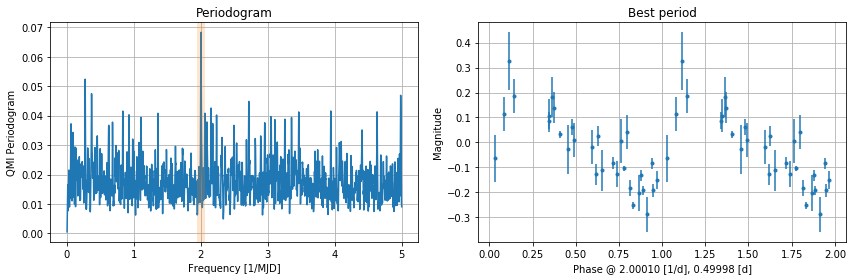

In [3]:
#my_per = P4J.periodogram(method='LKSL') # Lafler-Kinman's string length
#my_per = P4J.periodogram(method='PDM1') # Phase Dispersion Minimization
#my_per = P4J.periodogram(method='MHAOV') # Multi-harmonic Analysis of Variance
#my_per = P4J.periodogram(method='QME') # Quadratical mutual entropy or total correlation
#my_per = P4J.periodogram(method='QMICS') # Quadratic mutual information (QMI) based on Cauchy Schwarz distance
my_per = P4J.periodogram(method='QMIEU') # QMI based on Euclidean distance

my_per.set_data(mjd, mag, err)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-3)  # frequency sweep parameters
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('QMI Periodogram')
plt.title('Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([mag[idx], mag[idx]]),
            np.concatenate([err[idx], err[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout();

## Significance of the detected period

For a periodic time series with an oscillation frequency $f$, its periodogram will exhibit a peak at $f$ with high probability. But  the  inverse  is  not  necessarily  true,  a  peak in  the  periodogram  does  not  imply  that  the  time  series  is periodic.  Spurious  peaks  may  be  produced  by  measurement errors, random fluctuations, aliasing or noise.

We can test if the candidate frequencies (periodogram peaks) are statistically significant using bootstrap. This gives a principled way to test wheter the light curve is periodic or not. The core idea is to obtain the distribution of the maximum values of the periodogram on a set of surrogate light curves obtained by random-resampling. The general procedure is

For the null hypothesis that the light curve is not periodic 
1. Generate surrogate light curves  that comply with the null hypothesis 
2. Compute the periodogram for each surrogate and save the maxima 
3. Fit a extreme value probability density function (PDF) to the surrogate's maxima
4. For a given significance level (p-value) $\alpha$* obtain the associated confidence level from the fitted PDF  
5. If the candidate frequency has a periodogram value greater than the confidence level then you can reject the null hypothesis (for the selected $\alpha$)

*$\alpha$: Probability of rejecting the null hypothesis when it is actually true

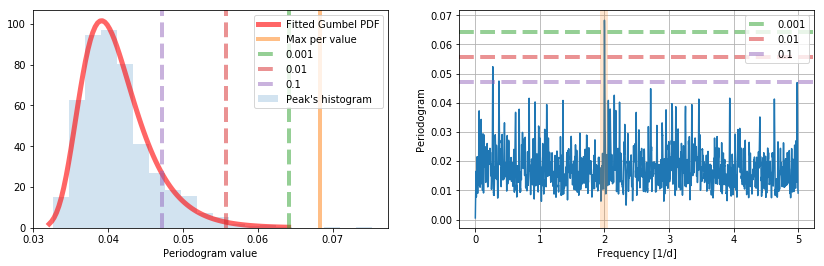

In [4]:
from scipy.stats import  gumbel_r  # Gumbel right (for maxima), its has 2 parameters
#from scipy.stats import  genextreme  # Generalized extreme value distribution, it has 3 parameters

# We will use 100 surrogates and save 10 local maxima per light curve
pbest_bootstrap = np.zeros(shape=(100, 10))
for i in range(pbest_bootstrap.shape[0]):
    P = np.random.permutation(len(mjd))
    my_per.set_data(mjd, mag[P], err[P])
    my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=pbest_bootstrap.shape[1])
    _, pbest_bootstrap[i, :] = my_per.get_best_frequencies()

param = gumbel_r.fit(pbest_bootstrap.ravel())
rv = gumbel_r(loc=param[0], scale=param[1])
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 100)
fig = plt.figure(figsize=(14, 4)) 
ax = fig.add_subplot(1, 2, 1)
_ = ax.hist(pbest_bootstrap.ravel(), bins=20, density=True, alpha=0.2, label='Peak\'s histogram')
ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='Fitted Gumbel PDF')
ymin, ymax = ax.get_ylim()
ax.plot([pbest[0], pbest[0]], [ymin, ymax], '-', linewidth=4, alpha=0.5, label="Max per value")
for p_val in [1e-3, 1e-2, 1e-1]:
    ax.plot([rv.ppf(1.-p_val), rv.ppf(1.-p_val)], [ymin, ymax], '--', linewidth=4, alpha=0.5, label=str(p_val))
ax.set_ylim([ymin, ymax])
plt.xlabel('Periodogram value'); plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], '-', linewidth=8, alpha=0.2)
# Print confidence bars
xmin, xmax = ax.get_xlim()
for p_val in [1e-3, 1e-2, 1e-1]:
    ax.plot([xmin, xmax], [rv.ppf(1.-p_val), rv.ppf(1.-p_val)], '--', linewidth=4, alpha=0.5, label=str(p_val))
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/d]'); ax.set_ylabel('Periodogram')
plt.grid(); plt.legend();

### Notes and references

In this example we used the the Gumbel extreme-value distribution to fit the periodogram peaks. A more flexible option is the generalized extreme value distribution from which Gumbel is a special case.

I recommend the following if you want to delve deeper on bootstrap and extreme-value distributions applied for astronomy
- M. Süveges, "False Alarm Probability based on bootstrap and extreme-value methods for periodogram peaks.", *ADA7-Seventh Conference on Astronomical Data Analysis*, v. 1, 2012. http://ada7.cosmostat.org/ADA7_proceeding_MSuveges2.pdf

And this one for bootstrap applied to time series in general
- P. Bühlmann, "Bootstraps for time series.", *Statistical Science*, 52-72, 2002